<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/1-vae/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Implementation

## Set up

In [27]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [28]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/DL-Project'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/DL-Project/data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/DL-Project/models'
if not os.path.exists(models_directory): os.makedirs(models_directory)

## Data

In [30]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])

In [31]:
trainset = torchvision.datasets.EuroSAT(root='./data',
                                            download=True, transform=transform)

In [32]:
trainset[0][0].shape

torch.Size([3, 64, 64])

In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=2)

In [34]:
print("[LOG] Total number of batches in the dataloader: %d" %len(trainloader))

[LOG] Total number of batches in the dataloader: 1688


### Plot images

In [37]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [51]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
)

GroundTruth:  Residential Residential Residential Residential River PermanentCrop AnnualCrop AnnualCrop Highway SeaLake Highway Highway HerbaceousVegetation SeaLake Highway AnnualCrop


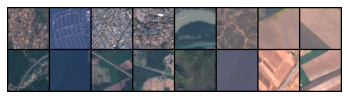

In [52]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))

## Model

In [35]:
def create_model():
    autoencoder = Autoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [36]:
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [38]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [39]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 64, 64]
        # Output size: [batch, 3, 64, 64]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 16, 16]
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 8, 8]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			        nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
              nn.ReLU(),
		  	      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
              nn.ReLU(),
              nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
              nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [40]:
parser = argparse.ArgumentParser(description="Train Autoencoder")
parser.add_argument("--valid", action="store_true", default=False,
                    help="Perform validation only.")

# Create model
autoencoder = create_model()

============== Encoder ==============
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
)

Model moved to GPU in order to speed up training.


In [41]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in autoencoder.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 47355.


In [42]:
# Define an optimizer and criterion
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters())

train_epoch_loss = []

In [55]:
for epoch in range(10):
    running_loss = 0.0
    
    for i, (inputs, _) in enumerate(trainloader, 0):
        inputs = get_torch_vars(inputs)

        # ============ Forward ============
        encoded, outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 1688 == 1687:
              print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, loss.data))
              #(epoch + 1, i + 1, loss.data))
        running_loss = 0.0

print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder.state_dict(), "./weights/autoencoder.pkl")

[1,  1688] loss: 0.561
[2,  1688] loss: 0.589
[3,  1688] loss: 0.617
[4,  1688] loss: 0.635
[5,  1688] loss: 0.622
[6,  1688] loss: 0.599
[7,  1688] loss: 0.555
[8,  1688] loss: 0.579
[9,  1688] loss: 0.599
[10,  1688] loss: 0.580
Finished Training
Saving Model...


GroundTruth:  SeaLake Forest Industrial SeaLake Residential Industrial SeaLake HerbaceousVegetation Forest HerbaceousVegetation Industrial Highway Highway Industrial HerbaceousVegetation PermanentCrop


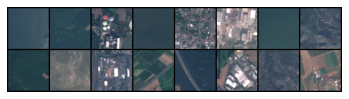

In [61]:
autoencoder.load_state_dict(torch.load("./weights/autoencoder.pkl"))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

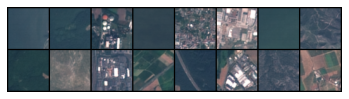

In [62]:
decoded_imgs = autoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))